In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from ast import literal_eval

## Cargo los Datasets

In [2]:
df_sentiment = pd.read_csv("./data/predicted/sentiment_predicted.csv")
df_veracity_arg = pd.read_csv("./data/predicted/veracity_arg_predicted.csv")
df_veracity = pd.read_csv("./data/predicted/veracity_predicted.csv")

In [3]:
def split_list(row):
    return pd.Series(row)

In [4]:
def convert_list(df,feature):
  df[feature] = df[feature].apply(literal_eval)
  df[[f'{feature}_false', f'{feature}_true']] = df[feature].apply(split_list)
  return df

In [5]:
def parse_df(df):
  df = convert_list(df,'sentiment_probabilities')
  df = convert_list(df,'veracity_probabilities')
  return df

In [6]:
df_veracity_arg = parse_df(df_veracity_arg)
df_veracity_global = parse_df(df_veracity)

In [7]:
df_veracity_total = pd.concat([df_veracity,df_veracity_arg])

In [8]:
df_sentiment = convert_list(df_sentiment,'sentiment_probabilities')

In [9]:
def plot_confusion_matrix(df_1,df_2,title,x_label,y_label):
  conf_matrix = confusion_matrix(df_1, df_2)

  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
  plt.title(title)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.show()

## Metricas

In [10]:
def calculate_metrics(target,predicted):
  accuracy = accuracy_score(target,predicted)
  precision = precision_score(target,predicted)
  recall = recall_score(target,predicted)
  f1 = f1_score(target,predicted)

  return accuracy,precision,recall,f1

In [11]:
def print_metrics(target,predicted):
    accuracy,precision,recall,f1 = calculate_metrics(target, predicted)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)
    return accuracy,precision,recall,f1

### Sentimiento

In [12]:
df_test = df_sentiment[df_sentiment['sentimiento'] != "Neutral"]
df_test['sentimiento'] = df_test['sentimiento'].replace({'Positivo':1, 'Negativo':0})

/tmp/ipykernel_6950/528608625.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['sentimiento'] = df_test['sentimiento'].replace({'Positivo':1, 'Negativo':0})


In [13]:
accuracy,precision,recall,f1 = print_metrics(df_test['sentimiento'], df_test['sentiment_label'])

Accuracy: 0.947538407821229
Precision: 0.9443273621355813
Recall: 0.9498321851263027
F1-score: 0.947071774548657


### Veracidad

#### Argentina

In [14]:
accuracy,precision,recall,f1 = print_metrics(df_veracity_arg['clasificacion'], df_veracity_arg['veracity_label'])

Accuracy: 0.7617053673391702
Precision: 0.6060885608856088
Recall: 0.7675233644859814
F1-score: 0.677319587628866


#### Global

In [15]:
accuracy,precision,recall,f1 = print_metrics(df_veracity_global['clasificacion'], df_veracity_global['veracity_label'])

Accuracy: 0.857602463022089
Precision: 0.8122260534159312
Recall: 0.980002256444971
F1-score: 0.8882611224378927


#### Total

In [16]:
accuracy,precision,recall,f1 = print_metrics(df_veracity_total['clasificacion'], df_veracity_total['veracity_label'])

Accuracy: 0.855593566342113
Precision: 0.8096469257493738
Recall: 0.9774678111587983
F1-score: 0.8856776702461443


### Set Thresholds

In [17]:
def add_threshold_label(df,threshold,feature):
    df[f'veracity_label_{threshold}'] =  (df[feature] >= threshold).astype(int)
    return df

In [20]:
def try_thresholds(df,rate,feature,target,threshold = 0.1):
    max_accuracy = 0
    max_accuracy_threshold = 0
    max_f1 = 0
    max_f1_threshold = 0
    while threshold <= 0.9:
        label_threshold = (df[feature] >= threshold).astype(int)
        accuracy,precision,recall,f1 = calculate_metrics(df[target], label_threshold)
        if accuracy > max_accuracy:
            max_accuracy = accuracy
            max_accuracy_threshold = threshold
        if f1 > max_f1:
            max_f1 = f1
            max_f1_threshold = threshold
        threshold += rate 
    
    print(f"Para el threshold {max_accuracy_threshold} se obtuvo el mejor acuraccy: {max_accuracy}")
    print(f"Para el threshold {max_f1_threshold} se obtuvo el mejor f1: {max_f1}")

    return max_accuracy_threshold,max_f1_threshold



In [21]:
rate = 0.01
accuracy_threshold,f1_threshold = try_thresholds(df_veracity_total,rate,'veracity_probabilities_true','clasificacion')


Para el threshold 0.5300000000000004 se obtuvo el mejor acuraccy: 0.8558886151049018
Para el threshold 0.4600000000000003 se obtuvo el mejor f1: 0.8861786575562701


In [29]:
threshold = 0.46
df_veracity_total =  add_threshold_label(df_veracity_total,threshold,'veracity_probabilities_true')

In [30]:
accuracy,precision,recall,f1 = print_metrics(df_veracity_total['clasificacion'], df_veracity_total[f'veracity_label_{threshold}'])

Accuracy: 0.8554739519788203
Precision: 0.8066264233776924
Recall: 0.9831391784181484
F1-score: 0.8861786575562701


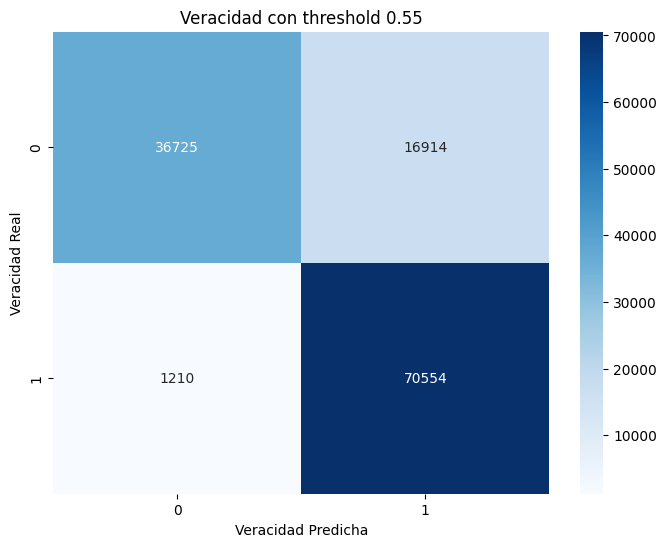

In [31]:
plot_confusion_matrix(df_veracity_total['clasificacion'], df_veracity_total[f'veracity_label_{threshold}'],'Veracidad con threshold 0.55','Veracidad Predicha','Veracidad Real')